In [ ]:
!pip install pyspark --quiet
#Generic Libraries
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
spark = SparkSession.builder.appName("Heart_Attack").getOrCreate()

In [ ]:
df = spark.read.csv("/content/heartattack.csv",header=True, inferSchema=True)

In [ ]:
df.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
| 57|  1|  0|     140| 192|  0|      1|    148|    0|    0.4|    1|  0|   1|     1|
| 56|  0|  1|     140| 294|  0|      0|    153|    0|    1.3|    1|  0|   2|     1|
| 44|  1|  1|     120| 263|  0|      1|    173|    0|    0.0|    2|  0|   3|     1|
| 44|  1|  1|     120| 263|  0|      1|    173|    0|    0.0|    2|  0|   3|

In [ ]:

from sklearn import tree
import graphviz

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [ ]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,303,54.33993399339934,9.100612525539113,29,77
sex,303,0.6831683168316832,0.46601082333962385,0,1
cp,303,0.9636963696369637,1.0303356684219658,0,3
trestbps,303,131.45214521452147,17.395578347530403,94,200
chol,303,246.47524752475246,51.76787096990188,126,564
fbs,303,0.14521452145214522,0.35289981813927573,0,1
restecg,303,0.528052805280528,0.525859596359298,0,2
thalach,303,149.68316831683168,22.933504810836492,71,202
exang,303,0.32673267326732675,0.46979446452231655,0,1


In [ ]:
df.groupBy('sex').count().show()

+---+-----+
|sex|count|
+---+-----+
|  1|  207|
|  0|   96|
+---+-----+



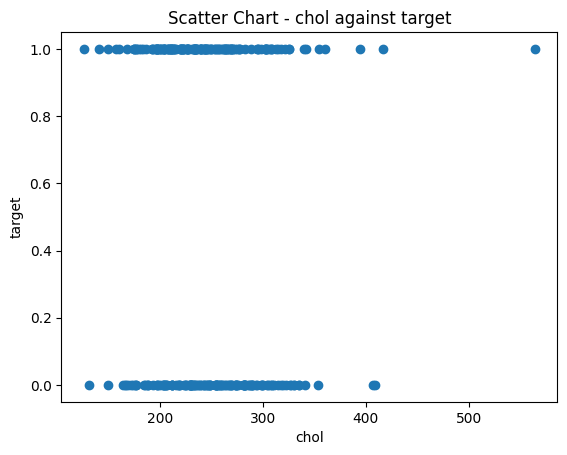

In [ ]:
import matplotlib.pyplot as plt
pandas_DF = df.toPandas()

plt.scatter(pandas_DF['chol'], pandas_DF['target'])

plt.title("Scatter Chart - chol against target")

# Setting the X and Y labels
plt.xlabel('chol')
plt.ylabel('target')

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x78865e7d9900>,
 'caps': [<matplotlib.lines.Line2D at 0x78865e7d85e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x78865e7dbcd0>],
 'medians': [<matplotlib.lines.Line2D at 0x78865e7db7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x78865e7da890>],
 'means': []}

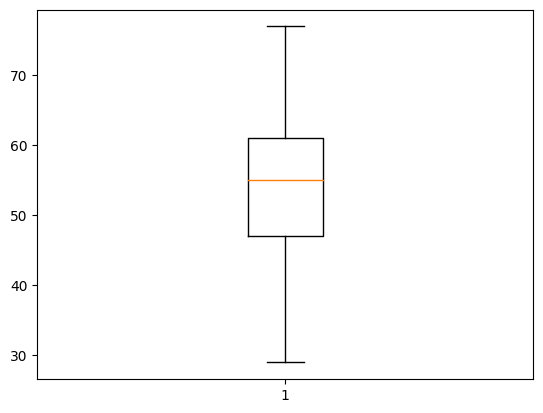

In [ ]:
plt.boxplot(pandas_DF['age'])

In [ ]:
balance_data = pd.read_csv('/content/heartattack.csv')
balance_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [ ]:
X = balance_data[['age','sex','cp', 'trestbps','chol', 'fbs','restecg', 'exang','oldpeak','slope','ca','thal']]
Y = balance_data[['target']]

In [ ]:
print(X)

     age  sex  cp  trestbps  chol  fbs  restecg  exang  oldpeak  slope  ca  \
0     63    1   3       145   233    1        0      0      2.3      0   0   
1     37    1   2       130   250    0        1      0      3.5      0   0   
2     41    0   1       130   204    0        0      0      1.4      2   0   
3     56    1   1       120   236    0        1      0      0.8      2   0   
4     57    0   0       120   354    0        1      1      0.6      2   0   
..   ...  ...  ..       ...   ...  ...      ...    ...      ...    ...  ..   
298   57    0   0       140   241    0        1      1      0.2      1   0   
299   45    1   3       110   264    0        1      0      1.2      1   0   
300   68    1   0       144   193    1        1      0      3.4      1   2   
301   57    1   0       130   131    0        1      1      1.2      1   1   
302   57    0   1       130   236    0        0      0      0.0      1   1   

     thal  
0       1  
1       2  
2       2  
3       2  
4  

In [ ]:
print(Y)

     target
0         1
1         1
2         1
3         1
4         1
..      ...
298       0
299       0
300       0
301       0
302       0

[303 rows x 1 columns]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, train_size=0.80, test_size=0.20, random_state=1)

In [ ]:
# Create Decision Tree Classifier Object
model = DecisionTreeClassifier()

# Train Decision Classifier
model = model.fit(X_train, y_train)

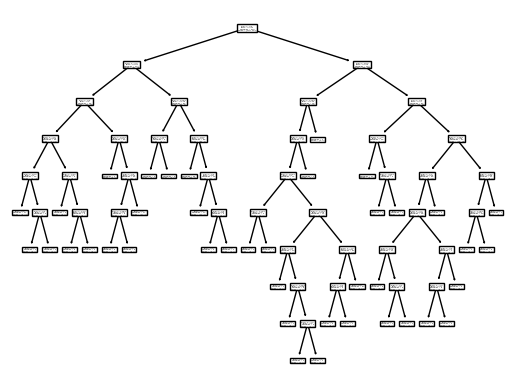

In [ ]:
tree.plot_tree(model);

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6721311475409836


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[21  9]
 [11 20]]
